# Содержание
1.  Подготовка данных
    - Загрузка файлов и просмотр данных
    - Проверка рассчета эффективности обогащения
    - Анализ признаков, недоступных в тестовой выборке
    -  Выводы по разделу 1
2.  Анализ данных
    - Исследование суммарной концентрации всех веществ
    - Изменение концентрации металлов на различных этапах очистки
    - Сравнение распределения размера гранул сырья
    - Выводы по разделу 2
3.  Модель
    -  Функция sMAPE
    -  Подговка данных для моделей
    -  Подбор параметров моделей
    -  Проверка модели на тестовой выборке
    -  Сравнение со случайной моделью
    -  Выводы по разделу 3
4.  Общий вывод
5.  Чек-лист готовности проекта

# Восстановление золота из руды

Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. Используйте данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Вам нужно:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

Чтобы выполнить проект, обращайтесь к библиотекам *pandas*, *matplotlib* и *sklearn.* Вам поможет их документация.

# Описание проекта
Данные находятся в трёх файлах:
- *gold_recovery_train_new.csv* — обучающая выборка;
- *gold_recovery_test_new.csv* — тестовая выборка;
- *gold_recovery_full_new.csv* — исходные данные.

Данные индексируются датой и временем получения информации (признак *date*). Соседние по времени параметры часто похожи.

Некоторые параметры недоступны, потому что замеряются и/или рассчитываются значительно позже. Из-за этого в тестовой выборке отсутствуют некоторые признаки, которые могут быть в обучающей. Также в тестовом наборе нет целевых признаков.

Исходный датасет содержит обучающую и тестовую выборки со всеми признаками.

В вашем распоряжении сырые данные: их просто выгрузили из хранилища. Прежде чем приступить к построению модели, проверьте по нашей инструкции их на корректность.

## Подготовка данных

### Загрузка файлов и просмотр данных
**Подключаем необходимые библиотеки и делаем необходимые настройки.**

In [1]:
import warnings
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.dummy import DummyRegressor

warnings.simplefilter('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

**Открываем файлы.** 

In [2]:
full_data = pd.read_csv('gold_recovery_full_new.csv')

In [3]:
test_data = pd.read_csv('gold_recovery_test_new.csv')

In [4]:
train_data = pd.read_csv('gold_recovery_train_new.csv')

**Перед просмотром данных, напишем две функции для подсчета количества строк и столбцов, содержащих пропуски.**

In [5]:
# Функция для подсчета количества строк таблицы, содержащих пропуски
get_skipped_values_str = lambda data: len(data[data.isna().sum(axis=1) >= 1])

# Функция для подсчета количества столбцов таблицы, содержащих пропуски
get_skipped_values_column = lambda data: data.isna().any().sum()

**Теперь напишем функцию для получения инофрмации о данных.**

In [6]:
def get_info(data, name):
    '''Функция для вывода информации о датафрейме.
    Получает на вход имя датафрейма и название таблицы.    
    Выводит: 
    - первые 5 строк;
    - количество строк и столбцов датафрейма;
    - общую информацию; 
    - количество явных дубликатов. 
    '''
    print('-' * 100)
    print(f'Первые 5 строк таблицы {name}:')
    display(data.head())    
    print('-' * 100)
    print(f'Общая информация о данных {name}:')
    print()
    print(data.info())
    print('-' * 100)
    print(f'Таблица {name} содержит {data.shape[0]} строк и столбцов {data.shape[1]}')
    print('-' * 100)    
    print(f'Количество строк таблицы {name}, содержащих пропуски: {get_skipped_values_str(data)}')
    print('-' * 100)   
    print(f'Количество столбцов таблицы {name}, содержащих пропуски: {get_skipped_values_column(data)}')    
    print('-' * 100)
    print(f'Количество явных дубликатов в таблице {name}: {data.duplicated().sum()}')
    print('-' * 100)
    print(f'Количество дубликатов в таблице {name} по столбцу date: {data.duplicated().sum()}')
    print('-' * 100)
    print()

**Посмотрим информацию по датафреймам.**

In [7]:
get_info(full_data, 'full_data')

----------------------------------------------------------------------------------------------------
Первые 5 строк таблицы full_data:


,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,10.296251,7.25,1.002663,8.558743,10.

----------------------------------------------------------------------------------------------------
Общая информация о данных full_data:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   final.output.concentrate_ag                         19438 non-null  float64
 2   final.output.concentrate_pb                         19438 non-null  float64
 3   final.output.concentrate_sol                        19228 non-null  float64
 4   final.output.concentrate_au                         19439 non-null  float64
 5   final.output.recovery                               19439 non-null  float64
 6   final.output.tail_ag                                19438 non-null  float64
 7   final.output.tail_

In [8]:
get_info(train_data, 'train_data')

----------------------------------------------------------------------------------------------------
Первые 5 строк таблицы train_data:


,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,10.296251,7.25,1.002663,8.558743,10.

----------------------------------------------------------------------------------------------------
Общая информация о данных train_data:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail

In [9]:
get_info(test_data, 'test_data')

----------------------------------------------------------------------------------------------------
Первые 5 строк таблицы test_data:


,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,1399.001695,-499.485144,13.128569,5.636710,489.793655,62.710452,42.022440,12.084103,16.922877,6.153479,16.867518,6.150709,1001.849317,-350.301265,1249.738612,-399.107531,1249.750520,-399.396730,1198.287855,-399.488594,999.472250,-399.530962,949.566189,-398.180807,24.938200,-500.490963,14.947607,-500.013837,20.018166,-450.395995,13.987058,-449.831513,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,-499.240168,1399.508091,-500.416324,13.036280,5.526065,490.104534,61.961163,41.187903,11.918977,17.002532,5.999043,16.996063,6.002315,998.690785,-350.425704,1248.395457,-399.946025,1249.514451,-399.630810,1200.506459,-399.942434,1000.002114,-399.491528,950.200009,-405.787514,24.923466,-499.813963,14.930873,-500.764452,19.988503,-450.114024,14.092981,-450.059163,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,-502.151509,1399.497088,-499.715479,13.138412,5.426561,489.617969,66.903807,42.546294,12.091332,16.992520,5.850632,16.982096,5.853594,998.516720,-349.783538,1247.440748,-400.264330,1248.207204,-401.074405,1199.770026,-400.790582,999.925519,-399.236999,950.320481,-400.864340,24.908732,-500.304035,14.996511,-500.993821,20.039689,-450.263164,14.077881,-449.660997,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,-498.355873,1401.065165,-501.038738,12.400507,5.114758,476.618130,59.865919,41.060195,12.181597,16.532144,5.801935,16.515277,5.803657,1000.276604,-350.172597,1251.322675,-398.655289,1250.493702,-399.746728,1199.398691,-397.50

----------------------------------------------------------------------------------------------------
Общая информация о данных test_data:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5286 non-null   float64
 2   primary_cleaner.input.depressant            5285 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5286 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.sta

### Проверка рассчета эффективности обогащения
Проверим, что эффективность обогащения рассчитана правильно. 

Вычислим ее на обучающей выборке для признака *rougher.output.recovery* и найдем *MAE* между расчетами и значением признака. <br>
Для расчетов эффективности обогащения будем использовать формулу:

$$Recovery = \frac{C * (F - T)}{F * {C - T}}$$

где:
- *C* — доля золота в концентрате после флотации/очистки;
- *F* — доля золота в сырье/концентрате до флотации/очистки;
- *T* — доля золота в отвальных хвостах после флотации/очистки.

Для рассчета *MAE* будем использовать стандартную функцию *mean_absolute_error* из модуля *metrics* библиотеки *sklearn*.

Для расчета эффективности напишем функцию *roug_out_recov_contr_func*.

In [10]:
roug_out_recov_contr_func = lambda c, f, t: ((c * (f - t)) / (f * (c - t)) * 100)

**Применим функцию к обучающей выборке и выведем первые три строки датафрейма.**

In [11]:
train_data['rougher.output.recovery_control'] = roug_out_recov_contr_func(
    train_data['rougher.output.concentrate_au'],
    train_data['rougher.input.feed_au'], 
    train_data['rougher.output.tail_au']
    )

train_data.head(3)

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,rougher.output.recovery_control
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980,87.107763
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.6

**Теперь рассчитаем *MAE*.**

In [12]:
round(mean_absolute_error(train_data['rougher.output.recovery'], train_data['rougher.output.recovery_control']), 2)

0.0

**Метрика *MAE* равна нулю, признак *rougher.output.recovery* расчитан правильно.**

Удалим добавленный столбец, он больше не пригодится.

In [13]:
train_data.drop(columns='rougher.output.recovery_control', inplace=True)

### Анализ признаков, недоступных в тестовой выборке
Некоторые параметры недоступны, потому что замеряются и/или рассчитываются значительно позже. Из-за этого в тестовой выборке отсутствуют некоторые признаки, которые могут быть в обучающей. 

Проанализируем признаки, недоступные в тестовой выборке.

Для этого напишем функцию и применим ее к датафреймам.

In [14]:
def get_dif_columns(data1, data2):
    '''Функция для поиска признаков, которые есть в таблице data1, но нет в таблице data2.
    Получает на вход два датафрейма.    
    Возвращает список названий признаков.
    '''    
    return [column for column in data1.columns if column not in data2.columns]


get_dif_columns(train_data, test_data)

['final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.concentrate_au',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'final.output.tail_au',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'primary_cleaner.output.tail_au',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.au_pb_ratio',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.concentrate_au',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_pb',
 'rougher.output.ta

**Из списка видно**, что большинство признаков, недоступных в тестовой выборке содержат "*output*" и относятся к *параметрам продукта*; четыре сореджат *calculation* и относятся к расчетным характеристикам. Два их них (*rougher.output.recovery*, *final.output.recovery*) являются целевыми признаками.

Приведем признаки обучающей и тестовой выборок в одному виду: добавим в тестовую выборку целевые признаки, и исключим из обучающей выборки остальные. 

Так же для всех датафреймов столбец "*date*" переведем в индекс.	

In [15]:
# Удаление столбцов из обучающей выборки; перевод столбца "date" в индекс
train_data = (train_data[list(test_data.columns) + 
                          ['rougher.output.recovery', 'final.output.recovery']]
               .set_index('date'))
# Проверка
train_data.head(1)

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,rougher.output.recovery,final.output.recovery
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,127.092003,10.128295,7.25,0.988759,1549.775757,-498.91214,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,6.100378,2.284912,523.546326,55.486599,36.808594,6.48615,11.986616,6.00799,11.836743,6.005818,999.706909,-404.066986,1603.011353,-434.715027,1602.375,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.35498,-451.939636,25.853109,-498.526489,23.89366,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.84198,87.107763,70.541216


In [16]:
# Добавление столбцов с пустыми значениями в тестовую выборку; перевод столбца "date" в индекс 
test_data[['rougher.output.recovery', 'final.output.recovery']] = np.nan
test_data = test_data.set_index('date')

# Проверка
test_data.head(1)

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,rougher.output.recovery,final.output.recovery
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-09-01 00:59:59,210.800909,14.993118,8.08,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,1399.001695,-499.485144,13.128569,5.63671,489.793655,62.710452,42.02244,12.084103,16.922877,6.153479,16.867518,6.150709,1001.849317,-350.301265,1249.738612,-399.107531,1249.75052,-399.39673,1198.287855,-399.488594,999.47225,-399.530962,949.566189,-398.180807,24.9382,-500.490963,14.947607,-500.013837,20.018166,-450.395995,13.987058,-449.831513,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.31785,4.872511,-500.037437,26.705889,-499.709414,NaN,NaN


In [17]:
# Сортировка данных по дате; перевод столбца "date" в индекс
full_data = full_data.sort_values(by='date')
full_data = full_data.set_index('date')

# Проверка
full_data.head(3)

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.

**Посмотрим количество строк с пропусками обучающей выборки после удаления столбцов.**

In [18]:
get_skipped_values_str(train_data)

1470

Датафреймы *full_data* и *train_data* содержат 3345 и 3132 пропущенных строк, это 17.2% и 22.1% наблюдений соответственно. Такое количество наблюдений удалять не стоит. Учитывая, что соседние по времени параметры часто похожи, заполним пропуски в выборке значениями из соседних ячеек.

**Сначала заполним датафрейм *full_data*.**

In [19]:
full_data = full_data.fillna(method='ffill').fillna(method='bfill')

**Теперь из датафрейма full_data заполним обучающую и тестовую выборки.**

In [20]:
train_data.fillna(full_data, inplace=True)
test_data.fillna(full_data, inplace=True)

**Убедимся, что пропусков не осталось.**

In [21]:
print(full_data.isna().sum().sum())
print(train_data.isna().sum().sum())
print(test_data.isna().sum().sum())

0
0
0


### Выводы по разделу 1
- загружены данные и просмотрена основная информация по ним;
- явные дубликаты и дубликаты по дате отсутствуют;
- проведена проверка рассчета эффективности обогащения;
- проанализированы признаки, недоступные в тестовой выборке: целевые признаки добавлены в тестовую выборку, остальные признаки удалены из обучающей выборки;
- в таблицах обнаружены и заполнены пропущенные значения.

## Анализ данных

### Исследование суммарной концентрации всех веществ

**Для начала исследуем суммарные концентрации всех металлов на разных стадиях.**

In [22]:
data_concentration = pd.DataFrame()

data_concentration['rougher_input_feed'] = (full_data['rougher.input.feed_ag'] + 
 full_data['rougher.input.feed_pb'] + 
 full_data['rougher.input.feed_sol'] + 
 full_data['rougher.input.feed_au'])

data_concentration['rougher_output_concentrate'] = (full_data['rougher.output.concentrate_ag'] + 
 full_data['rougher.output.concentrate_pb'] + 
 full_data['rougher.output.concentrate_sol'] + 
 full_data['rougher.output.concentrate_au'])

data_concentration['primary_cleaner_output_concentrate'] = (full_data['primary_cleaner.output.concentrate_ag'] + 
 full_data['primary_cleaner.output.concentrate_pb'] + 
 full_data['primary_cleaner.output.concentrate_sol'] + 
 full_data['primary_cleaner.output.concentrate_au'])

data_concentration['final_output_concentrate'] = (full_data['final.output.concentrate_ag'] + 
 full_data['final.output.concentrate_pb'] + 
 full_data['final.output.concentrate_sol'] + 
 full_data['final.output.concentrate_au'])

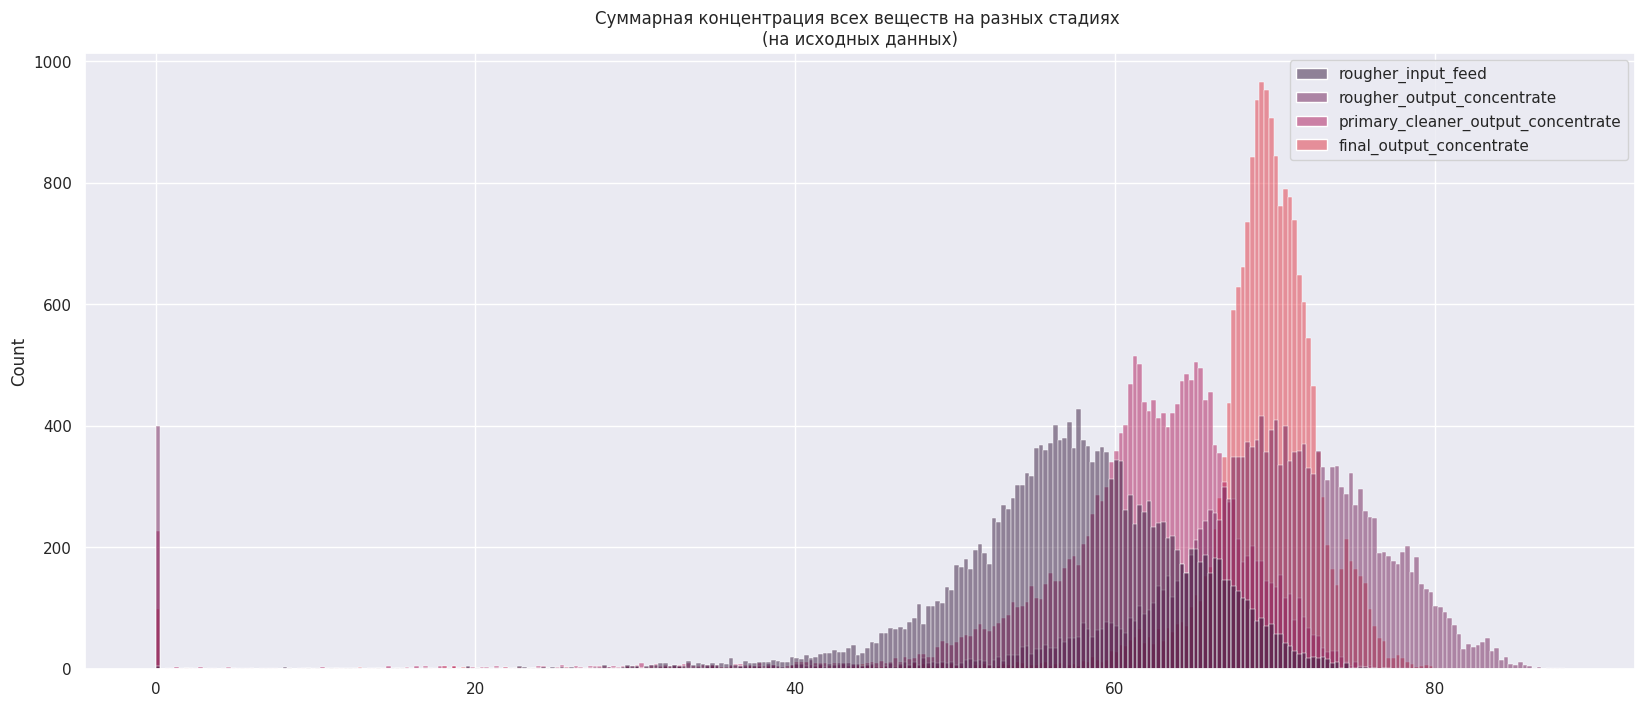

In [23]:
sns.set(rc={'figure.figsize':(20, 8)}, palette='rocket')

sns.histplot(data_concentration, bins=300) \
    .set(title='Суммарная концентрация всех веществ на разных стадиях \n(на исходных данных)')

plt.show()

**На графике заметны аномальные значения суммарной концентрации всех веществ в точке ноль.**

### Изменение концентрации металлов на различных этапах очистки

**Посмотрим, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки.**

Смотреть будем на датафрейме full_data, поскольку он содержит все данные.

Для этого напишет функцию *get_concentration*, которая будет заполнять заранее созданную таблицу *data_concentration*.

In [24]:
def get_concentration(metal_code: str, metal_name: str):
    data_concentration.loc[metal_name, 
                         ['rougher_input_concentr_mean']] = \
    full_data[f'rougher.input.feed_{metal_code}'].mean().round(2)    
    
    data_concentration.loc[metal_name, 
                         ['rougher_output_concentr_mean']] = \
    full_data[f'rougher.output.concentrate_{metal_code}'].mean().round(2)  
    
    data_concentration.loc[metal_name, 
                         ['primary_output_cleaner_concentr_mean']] = \
    full_data[f'primary_cleaner.output.concentrate_{metal_code}'].mean().round(2)  
    
    data_concentration.loc[metal_name, 
                         ['final_output_concentr_mean']] = \
    full_data[f'final.output.concentrate_{metal_code}'].mean().round(2)     

In [25]:
data_concentration = pd.DataFrame()

get_concentration('au', 'aurum')
get_concentration('ag', 'argentum')
get_concentration('pb', 'plumbum')

data_concentration

,rougher_input_concentr_mean,rougher_output_concentr_mean,primary_output_cleaner_concentr_mean,final_output_concentr_mean
aurum,8.27,19.77,32.12,44.08
argentum,8.79,11.99,8.44,5.17
plumbum,3.59,7.61,9.81,9.98


**Визуализируем результат.**

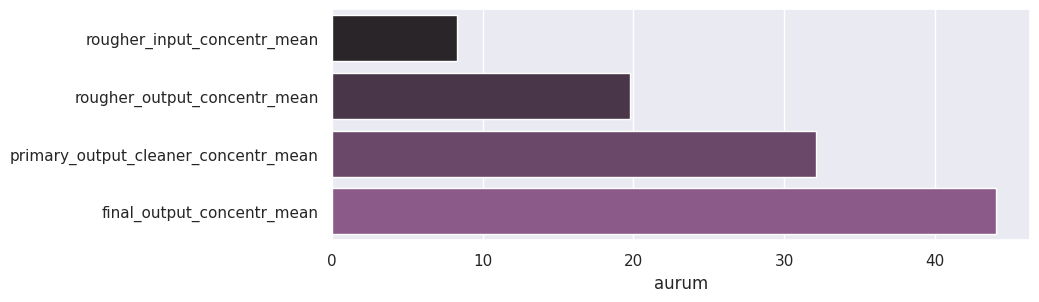

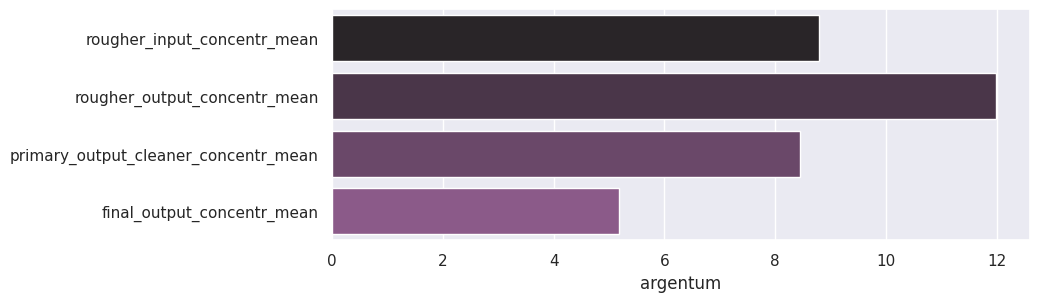

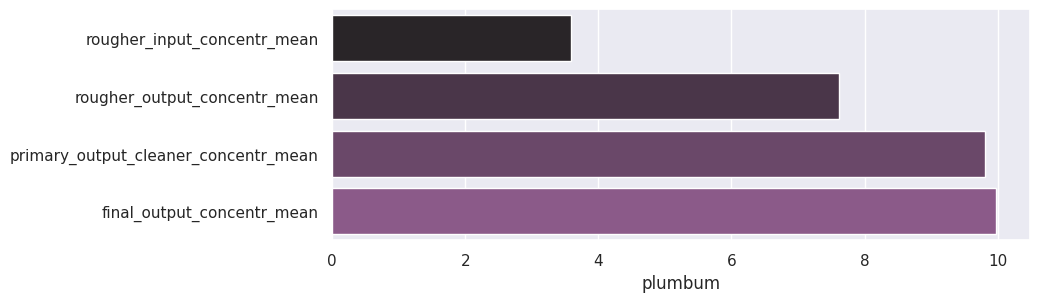

In [26]:
sns.set(rc={'figure.figsize':(9, 3)}, palette='dark:Orchid')

for i in data_concentration.index:
    sns.barplot(x=data_concentration.loc[i], 
                y =['rougher_input_concentr_mean', 
                    'rougher_output_concentr_mean', 
                    'primary_output_cleaner_concentr_mean', 
                    'final_output_concentr_mean'])
    
    plt.show()

**Из таблицы и графиков видно:** 
- средняя концентрация золота увеличивается на всех этапах обработки и в общей сложности возрастает в 5 раз;
- средняя концентрация свинца увеличивается на всех этапах обработки;
- средняя концентрация серебра уменьшается после этапа флотации.

**Для того, чтобы посмотреть аномальные значения концентрации веществ на разных этапах очистки, построим диаграммы размаха.**

Смотреть будем на датафрейме full_data, поскольку он содержит все данные.

Для этого напишем функцию.

In [27]:
def boxplot_building(metal, title, lim):
    '''Фукнция для постоения диаграмм размаха значений концентрации металлов на разных этапах очистки.
    Получает на вход сокращенное название металла (au, ag, pb), название графика и ограничение по оси y.
    Строит 4 диаграммы рядом.'''    
    sns.set(rc={'figure.figsize':(20, 9)}, palette=['#DDA0DD'])    
    pos = 1
    for column in ['rougher.input.feed_', 
                   'rougher.output.concentrate_',
                   'primary_cleaner.output.concentrate_',
                   'final.output.concentrate_']:                   
        plt.subplot(1, 4, pos)
        sns.boxplot(y=full_data[f'{column}{metal}']).set(ylim=(0, lim))
        sns.stripplot(y=full_data[f'{column}{metal}'], marker="^", alpha=0.1, color='#8B008B')
        pos += 1
                   
    plt.suptitle(title)
    plt.show()

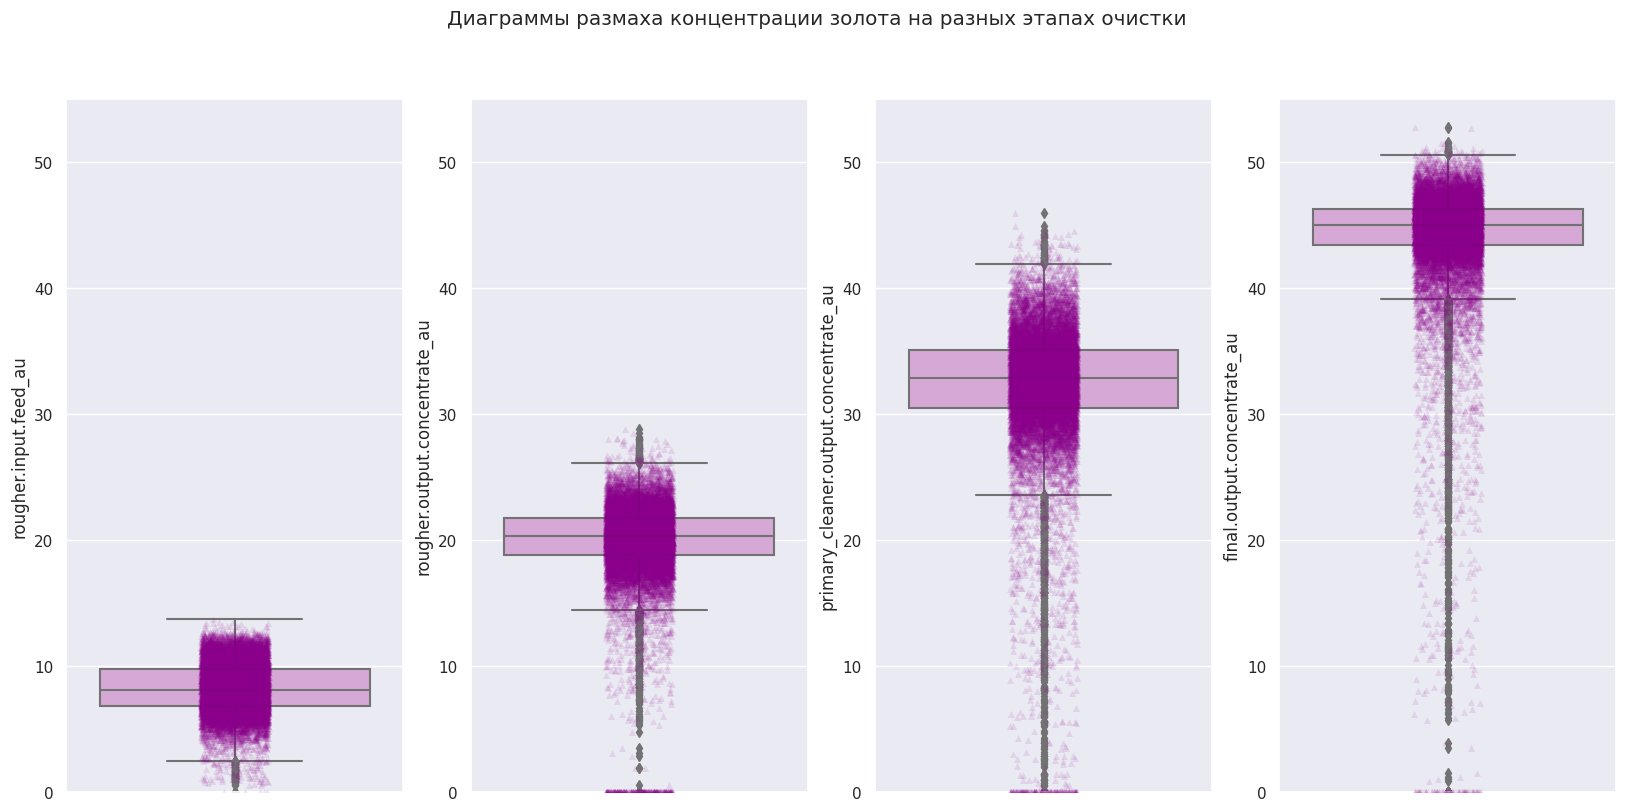

In [28]:
boxplot_building('au', 'Диаграммы размаха концентрации золота на разных этапах очистки', 55)

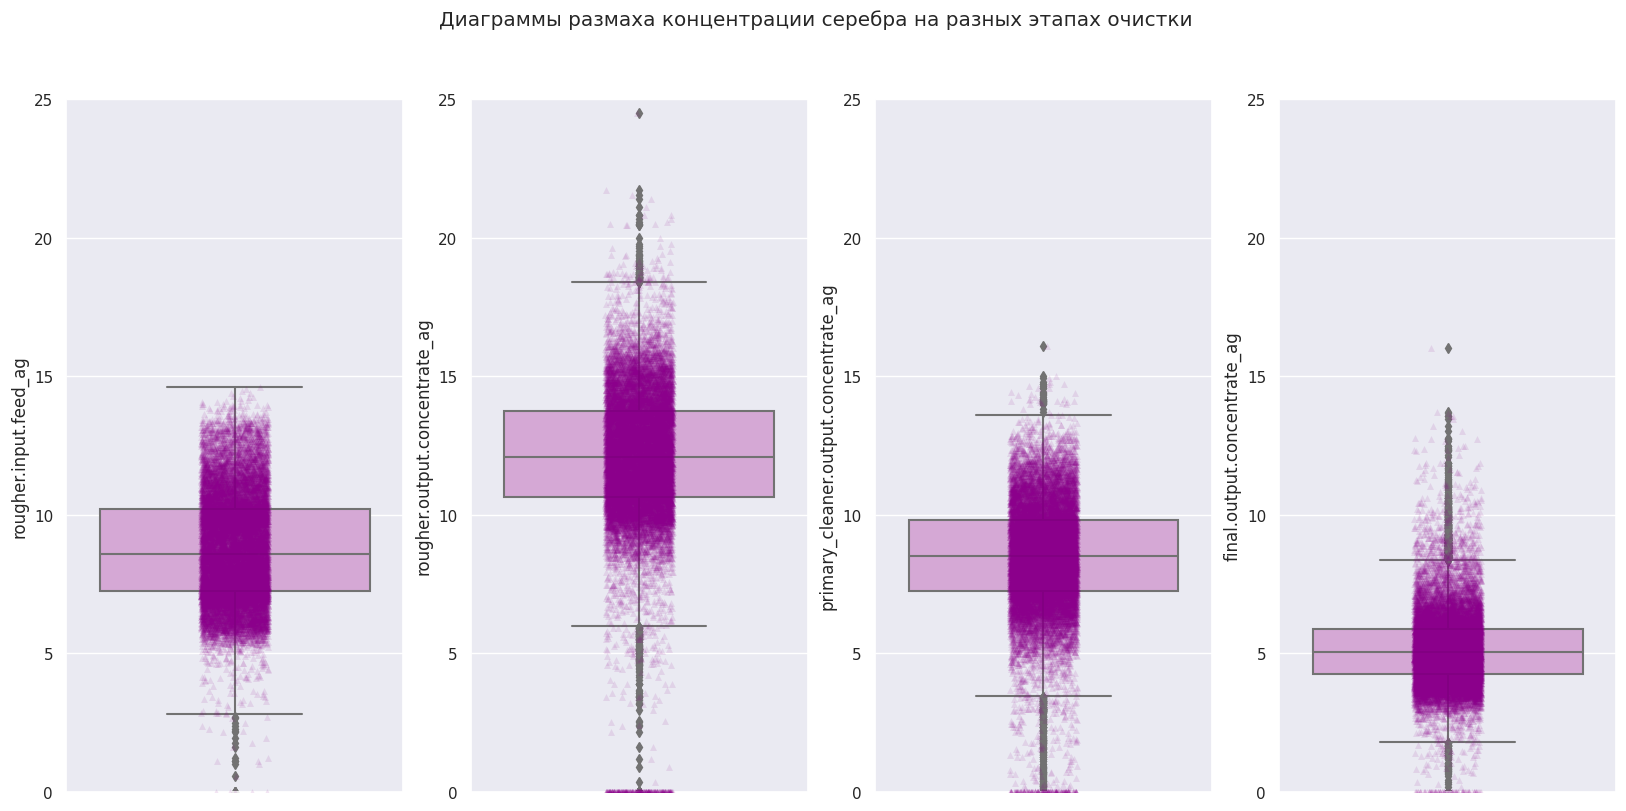

In [29]:
boxplot_building('ag', 'Диаграммы размаха концентрации серебра на разных этапах очистки', 25)

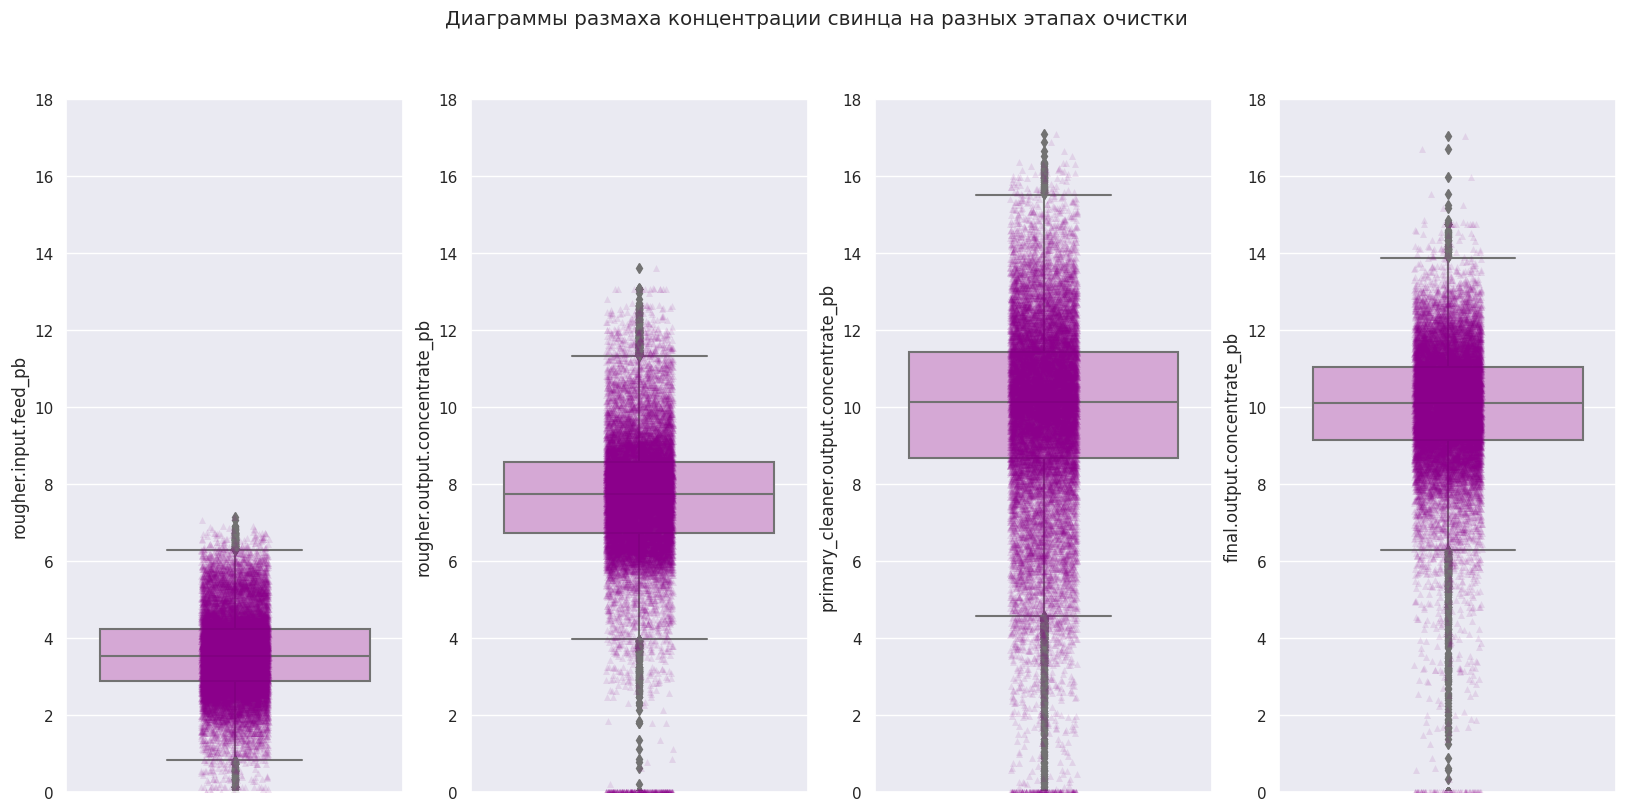

In [30]:
boxplot_building('pb', 'Диаграммы размаха концентрации свинца на разных этапах очистки', 18)

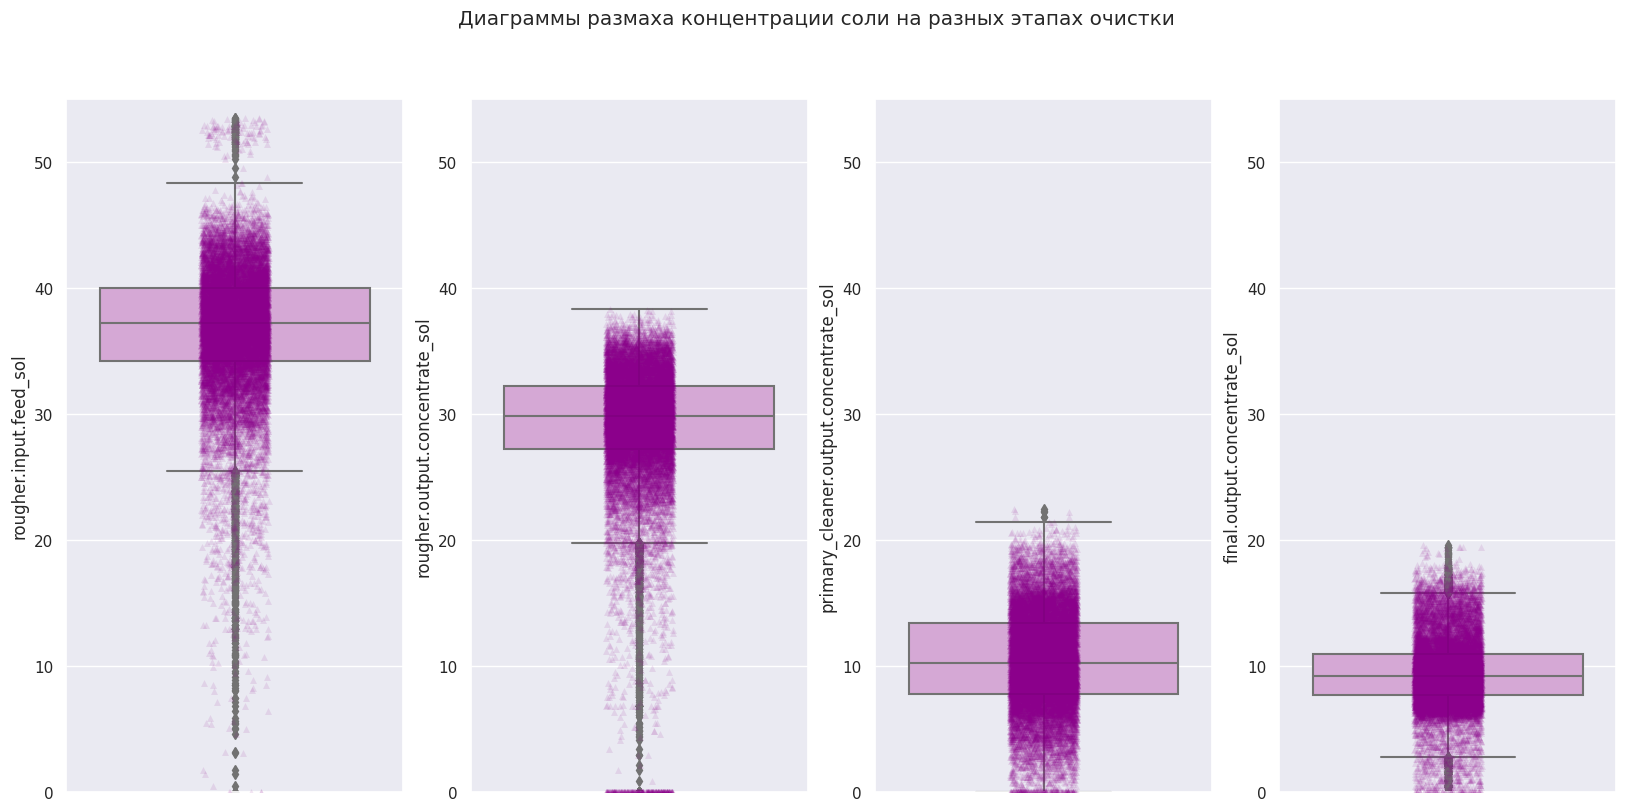

In [31]:
boxplot_building('sol', 'Диаграммы размаха концентрации соли на разных этапах очистки', 55)

**На диаграммах размаха для всех веществ видно, что начиная с этапа флотации появляются значения концентрации, равные нулю.**

**Такая ситуация похожа на ошибку в измерениях. Следует удалить эти строки из обучающей выборки.**

Заодно удалим выбросы, которые видны на диаграммах размаха.

In [32]:
train_data = train_data[full_data['rougher.input.feed_au'] > 1]

train_data = train_data[(full_data['rougher.output.concentrate_au'] > 5) &
                        (full_data['rougher.output.concentrate_au'] < 39)]

train_data = train_data[(full_data['primary_cleaner.output.concentrate_au'] > 10) &
                        (full_data['primary_cleaner.output.concentrate_au'] < 45)]

train_data = train_data[(full_data['final.output.concentrate_au'] > 18) &
                        (full_data['final.output.concentrate_au'] < 51)]


train_data = train_data[full_data['rougher.input.feed_ag'] > 2]

train_data = train_data[(full_data['rougher.output.concentrate_ag'] > 3) &
                        (full_data['rougher.output.concentrate_ag'] < 20)]

train_data = train_data[(full_data['primary_cleaner.output.concentrate_ag'] > 2) &
                        (full_data['primary_cleaner.output.concentrate_ag'] < 15)]

train_data = train_data[(full_data['final.output.concentrate_ag'] > 1) &
                        (full_data['final.output.concentrate_ag'] < 12)]


train_data = train_data[(full_data['rougher.input.feed_pb'] > 0.4) &
                        (full_data['rougher.input.feed_pb'] < 7) ]

train_data = train_data[(full_data['rougher.output.concentrate_pb'] > 2) &
                        (full_data['rougher.output.concentrate_pb'] < 13)]

train_data = train_data[(full_data['primary_cleaner.output.concentrate_pb'] > 2) &
                        (full_data['primary_cleaner.output.concentrate_pb'] < 16)]

train_data = train_data[(full_data['final.output.concentrate_pb'] > 5) &
                        (full_data['final.output.concentrate_pb'] < 15)]


train_data = train_data[(full_data['rougher.input.feed_sol'] > 15) &
                        (full_data['rougher.input.feed_sol'] < 51) ]

train_data = train_data[full_data['rougher.output.concentrate_sol'] > 10]

train_data = train_data[full_data['primary_cleaner.output.concentrate_sol'] > 0]

train_data = train_data[(full_data['final.output.concentrate_sol'] > 0.4) &
                        (full_data['final.output.concentrate_sol'] < 19)]

**Количество строк обучающей выборки было 14149. Проверим, что удалено не более 10% наблюдений.**

In [33]:
(14149 - len(train_data)) / 14149 * 100

6.544632129479115

**Удалено около 6.5% наблюдений.**

### Сравнение распределения размера гранул сырья
**Сравним распределение размеров гранул сырья на обучающей и тестовой выборках.**

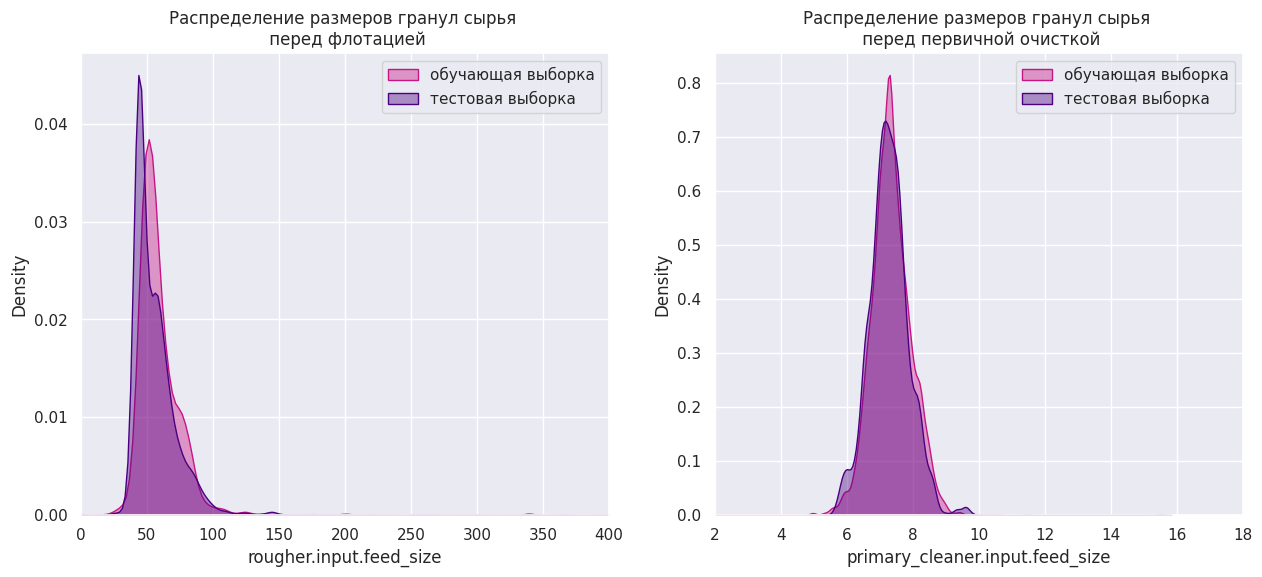

In [34]:
sns.set(rc={'figure.figsize':(15, 6)}, palette=['#C71585', '#4B0082'])

plt.subplot(1, 2, 1)
for data in [train_data, test_data]:
    sns.kdeplot(
        data=data['rougher.input.feed_size'],        
        shade=True,    
        alpha=0.4, 
        linewidth=1        
        ).set(xlim=(0, 400))
     
    plt.legend(['обучающая выборка', 'тестовая выборка'])
    plt.title('Распределение размеров гранул сырья \n перед флотацией')
    
plt.subplot(1, 2, 2)
for data in [train_data, test_data]:
    sns.kdeplot(
        data=data['primary_cleaner.input.feed_size'],        
        shade=True,    
        alpha=0.4, 
        linewidth=1        
        ).set(xlim=(2, 18))
     
    plt.legend(['обучающая выборка', 'тестовая выборка'])
    plt.title('Распределение размеров гранул сырья \n перед первичной очисткой')
    
plt.show()

**Судя по графикам, распределения размеров гранул сырья отличаются несильно.**

На графиках заметна асимметрия (перекос вправо) за счет наличия больших значений. Это имеет принципиальное значения для обучающей выборки, поэтому построим диаграммы размаха, чтобы оценить ситуацию с выбросами.

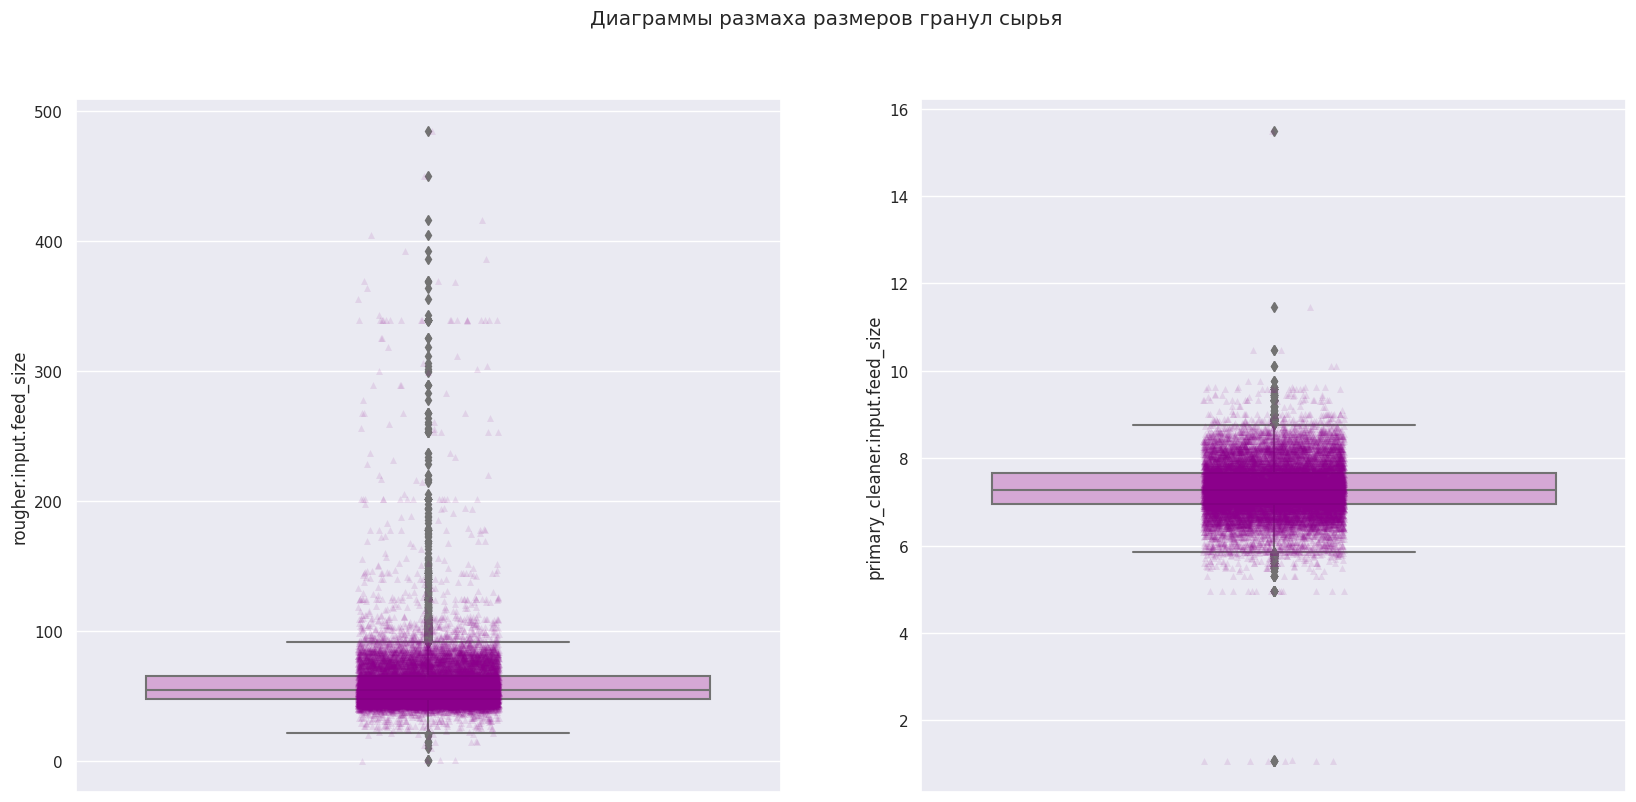

In [35]:
sns.set(rc={'figure.figsize':(20, 9)}, palette=['#DDA0DD'])
    
pos = 1
for column in ['rougher.input.feed_size', 
                'primary_cleaner.input.feed_size']:                   
    plt.subplot(1, 2, pos)
    sns.boxplot(y=full_data[f'{column}'])
    sns.stripplot(y=full_data[f'{column}'], marker="^", alpha=0.1, color='#8B008B')
    pos += 1
                   
plt.suptitle('Диаграммы размаха размеров гранул сырья')
plt.show()

**Удалим очень маленькие и очень большие значения.**

In [36]:
train_data = train_data[(full_data['rougher.input.feed_size'] < 120) & 
                        (full_data['rougher.input.feed_size'] > 10)]

train_data = train_data[(full_data['primary_cleaner.input.feed_size'] < 9.5) & 
                        (full_data['primary_cleaner.input.feed_size'] > 5.5)]

**Количество строк обучающей выборки было 14149. Проверим, что удалено не более 10% наблюдений.**

In [37]:
(14149 - len(train_data)) / 14149 * 100

7.965227224538837

**В два этапа всего удалено около 8% наблюдений.**

### Выводы по разделу 2
- средняя концентрация золота и свинца увеличивается на всех этапах обработки, средняя концентрация серебра уменьшается после этапа флотации;
- распределения размеров гранул сырья отличаются несильно;
- концентрация металлов на разных стадиях растет;
- концентрация всех веществ остается примерно одинаковой;
- в процессе исследования концентраций удалены аномальные значения и выбросы.

## Модель

### Функция sMAPE
**Для начала напишем функцию *sMAPE*.**

Для этого будем использовать формулу:<br>

$$sMAPE = \frac{1}{N} \sum_{i=1}^{N} \frac{|y_i - ŷ_i|} {(|y_i| + |ŷ_i|) / 2} * 100\%$$


In [38]:
def smape(targ, pred):
    '''Функция для вычисления метрики качества sMAPE.
    Получает на вход целевой признак и предсказания.
    Возвращает значение метрики sMAPE.
    '''    
    return (100 / (len(targ)) * (2 * (abs(targ - pred)) / (abs(targ) + abs(pred)))).sum()

**Теперь напишем функцию для *итогового sMAPE*.**

Для этого будем использовать формулу:<br>

$$Итоговое\ \ sMAPE = 25\% * sMAPE(rougher) + 75\% * sMAPE(final)$$

In [39]:
def final_smape(smape_rougher, smape_final):
    '''Функция для вычисления итогового sMAPE.
    Получает на вход sMAPE этапа флотации и sMAPE финального этапа.
    Возвращает значение метрики итогового sMAPE.
    ''' 
    return 0.25 * smape_rougher + 0.75 * smape_final

**Для оценки качества моделей на основе созданной метрики, создадим *кастомный scorer*.**

In [40]:
smape_score = make_scorer(smape, greater_is_better=False)

### Подговка данных для моделей

**Извлечем из обучающей и тестовый выборок признаки и целевые признаки.**

In [41]:
features_train = train_data.drop(['rougher.output.recovery', 'final.output.recovery'], axis=1)
features_test = test_data.drop(['rougher.output.recovery', 'final.output.recovery'], axis=1)

target_train_rougher = train_data['rougher.output.recovery']
target_train_final = train_data['final.output.recovery']

target_test_rougher = test_data['rougher.output.recovery']
target_test_final = test_data['final.output.recovery']

**Проверим размер полученных выборок.**

In [42]:
features_train.shape, target_train_rougher.shape, target_train_final.shape

((13022, 52), (13022,), (13022,))

In [43]:
features_test.shape, target_test_rougher.shape, target_test_final.shape

((5290, 52), (5290,), (5290,))

**Проверим соответсвие признаков обучающей и тестовой выборки.**

Если полученные списки пустые - расхождения нет.

In [44]:
get_dif_columns(features_train, features_test)

[]

In [45]:
get_dif_columns(features_test, features_train)

[]

**Обучающая и тестовая выборки содержат одинаковые признаки.**

### Подбор параметров моделей

**Подберем оптимальные параметры для Дерева решений для целевого признака *rougher.output.recovery*.**

In [46]:
model = DecisionTreeRegressor(random_state=12345)

model_dtr_params = {'splitter': ['best', 'random'],
                     'max_depth': range(1, 21),
                     'min_samples_split': range(2,21),
                     'min_samples_leaf': range(1,21)}

dtr = RandomizedSearchCV(model, model_dtr_params, scoring=smape_score, random_state=12345)

dtr.fit(features_train, target_train_rougher)
dtr_best_score_rougher = abs(dtr.best_score_)

print(dtr.best_params_ )
print(abs(dtr_best_score_rougher))

{'splitter': 'best', 'min_samples_split': 19, 'min_samples_leaf': 12, 'max_depth': 5}
6.353596234284422


**Оптимальные параметры:** *splitter*: 'best', *min_samples_split*: 19, *min_samples_leaf*: 12, *max_depth*: 5; <br> **значение *sMAPE*:** 6.353596234284422.

**Подберем оптимальные параметры для Дерева решений для целевого признака *final.output.recovery*.**

In [47]:
%%time
model = DecisionTreeRegressor(random_state=12345)

model_dtr_params = {'splitter': ['best', 'random'],
                     'max_depth': range(1, 21),
                     'min_samples_split': range(2,21),
                     'min_samples_leaf': range(1,21)}

dtr = RandomizedSearchCV(model, model_dtr_params, scoring=smape_score, random_state=12345)

dtr.fit(features_train, target_train_final)
dtr_best_score_final = abs(dtr.best_score_)

print(dtr.best_params_ )
print(abs(dtr_best_score_final))

{'splitter': 'random', 'min_samples_split': 7, 'min_samples_leaf': 18, 'max_depth': 3}
8.87382509210137
CPU times: user 5.88 s, sys: 0 ns, total: 5.88 s
Wall time: 5.88 s


**Оптимальные параметры:** *splitter*: 'random', *min_samples_split*: 7, *min_samples_leaf*: 18, *max_depth*: 3; <br> **значение *sMAPE*:** 8.87382509210137.

**Посчитаем значение *итогового sMAPE* для Дерева решений:**

In [48]:
final_smape(dtr_best_score_rougher, dtr_best_score_final)

8.243767877647134

**Значение *итогового sMAPE* для Дерева решений 8.243767877647134.**

**Подберем оптимальные параметры для Случайного леса для целевого признака *rougher.output.recovery*.**

In [49]:
%%time
model = RandomForestRegressor(random_state=12345)
model_rfr_params = {'n_estimators': range(1, 102, 50),
                    'max_depth': range(2, 21, 2),
                    'min_samples_split': range(2, 21, 2),
                    'min_samples_leaf': range(1, 21, 2)}

rfr = RandomizedSearchCV(model, model_rfr_params, scoring=smape_score, random_state=12345)

rfr.fit(features_train, target_train_rougher)
rfr_best_score_rougher = abs(rfr.best_score_)
    
print(rfr.best_params_)
print(abs(rfr_best_score_rougher))

{'n_estimators': 101, 'min_samples_split': 2, 'min_samples_leaf': 13, 'max_depth': 4}
5.984520196449043
CPU times: user 11min 1s, sys: 119 ms, total: 11min 1s
Wall time: 11min 1s


**Оптимальные параметры:** *n_estimators*: 101, *min_samples_split*: 2, *min_samples_leaf*: 13, *max_depth*: 4; <br> **значение *sMAPE*:** 5.984520196449043.

**Подберем оптимальные параметры для Случайного леса для целевого признака *final.output.recovery*.**

In [50]:
%%time
model = RandomForestRegressor(random_state=12345)
model_rfr_params = {'n_estimators': range(1, 102, 50),
                    'max_depth': range(2, 21, 2),
                    'min_samples_split': range(2, 21, 2),
                    'min_samples_leaf': range(1, 21, 2)}

rfr = RandomizedSearchCV(model, model_rfr_params, scoring=smape_score, random_state=12345)

rfr.fit(features_train, target_train_final)
rfr_best_score_final = abs(rfr.best_score_)
    
print(rfr.best_params_)
print(abs(rfr_best_score_final))

{'n_estimators': 51, 'min_samples_split': 16, 'min_samples_leaf': 5, 'max_depth': 4}
8.366210467384743
CPU times: user 12min 44s, sys: 75.9 ms, total: 12min 44s
Wall time: 12min 45s


**Оптимальные параметры:** *n_estimators*: 51, *min_samples_split*: 16, *min_samples_leaf*: 5, *max_depth*: 4; <br> **значение *sMAPE*:** 8.366210467384743.

**Посчитаем значение *итогового sMAPE* для Случайного леса:**

In [51]:
final_smape(rfr_best_score_rougher, rfr_best_score_final)

7.770787899650818

**Значение *итогового sMAPE* для Случайного леса 7.770787899650818.**

**Наилучший итоговый sMAPE получен с применением модели Случайного леса. Применим модели к тестовой выборке и посчитаем итоговый sMAPE.**

### Проверка модели на тестовой выборке
**Применим модели к тестовой выборке и посчитаем итоговый sMAPE.**

In [52]:
model = RandomForestRegressor(random_state=12345, 
                              n_estimators = 101,
                              max_depth = 4,
                              min_samples_split= 2,
                              min_samples_leaf = 13)
                             
model.fit(features_train, target_train_rougher)
pred_rougher = model.predict(features_test)
test_rougher_score = smape(target_test_rougher, pred_rougher)
test_rougher_score

8.07848310583952

In [53]:
model = RandomForestRegressor(random_state=12345, 
                              n_estimators = 51,
                              max_depth = 4,
                              min_samples_split= 16,
                              min_samples_leaf = 5)
                             
model.fit(features_train, target_train_final)
pred_final = model.predict(features_test)
test_final_score = smape(target_test_final, pred_final)
test_final_score

9.59097602821492

In [54]:
test_smape = final_smape(test_rougher_score, test_final_score)
test_smape

9.212852797621071

**Итоговый *sMAPE* на тестовых данных 9.212852797621071.**

### Сравнение со случайной моделью

**Создадим и обучим случайные модели для обоих признаков.**

In [55]:
dm_rougher = DummyRegressor()
dm_final = DummyRegressor()

dm_rougher.fit(features_train, target_train_rougher)
dm_final.fit(features_train, target_train_final)

DummyRegressor()

**Сделаем предсказания случайными моделями.**

In [56]:
dm_rougher_pred = dm_rougher.predict(features_test)
dm_final_pred = dm_final.predict(features_test)

**Найдем итоговый *sMAPE* для случайных моделей.**

In [57]:
final_smape(smape(target_test_rougher, dm_rougher_pred), 
            smape(target_test_final, dm_final_pred))

9.725171787263104

**Итоговый *sMAPE* случайной модели на тестовых данных 9.725171787263104.**

**Таким образом, по результату видно, что итоговый sMAPE на тестовых данных выбранной модели (≈9.21) меньше итогового sMAPE на тестовых данных случайной модели (≈9.73).**

### Выводы по разделу 3
- была написана функция для рассчета метрики *sMAPE* и создан scorer на основе этой функции;
- с помощью *RandomizedSearchCV* подобраны параметры моделей Дерево решений и Случайный лес, рассчитаны *итоговые sMAPE* и определена лучшая модель (Случайный лес);
- лучшая модель проверена на тестовой выборке и рассчитан *итоговый sMAPE* на тестовых данных;
- создана и обучена случайная модель, рассчитан *итоговый sMAPE* случайной модели;
- *итоговый sMAPE* случайной модели хуже *итогового sMAPE* лучшей модели.

## Общий вывод
1. В первом разделе было первое знакомство с данными: 
    - данные исследованы на *дубликаты*, выявлено, что дубликаты отсутствуют; 
    - обнаружены и заполнены *пропуски*; 
    - проведена проверка рассчета *эффективности обогащения*;
    - проанализированы *признаки*, недоступные в тестовой выборке; обучающая и тестовая выборки приведены к одному размеру, а их признаки приведены в соответствие.
2. Во втором разделе произведен более грубокий анализ данных:
    - исследовано *изменение концентрации металлов* на различных этапах очистки: концентрация золота и свинца возрастает, а концентрация серебра падает;
    - найдены и удалены *аномалии и выбросы*;
    - произведено *сравнение распределений размеров гранул сырья* на обучающей и тестовой выборках, размеры гранул различаются несильно;
    - исследована *суммарная концентрация всех веществ* на различных стадиях: суммарная концентрация металлов растет, а суммарная концентрация всех веществ остается почти неизменной.
3. Третий раздел был посвящен работе с моделями:
    - было создана *функция для метрики sMAPE* и scorer на основе этой функции, создана функция для рассчета *итогового sMAPE*;
    - датафреймы были поделены на признаки и целевые признаки;
    - для Дерева решений и Случайного леса были подобраны оптимальные параметры; результат *итогового sMAPE* лучше у модели Случайный лес **(≈9.21)**;
    - модель Случайный лес проверена на тестовой выборке и рассчитан *итоговый sMAPE*;
    - для проверки качества лучшей модели создана случайная модель *DummyRegressor*; для нее рассчитан *итоговый sMAPE* **(≈9.73)**;
    - по результатам *итоговых sMAPE* видно, что наша модель Случайный лес лучше (итоговый sMAPE меньше), чем случайная модель, что и являлось целью проекта.